In [ ]:
#Instalamos todos los paquetes e importamos las librerías que vamos a utilizar
!pip install spacy
!python -m spacy download es_core_news_md
!pip install transformers
!pip install top2vec[sentence_transformers]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from typing import TextIO
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
import spacy
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSeq2SeqLM
import re
import torch
from collections import Counter
from wordcloud import WordCloud



In [ ]:
#Guardamos en 4 listas los links a las páginas de las que sacaremos los textos

urlscocina = ['https://claudiaandjulia.com/blogs/general/patatas-asadas-crujientes-al-estilo-hasselback-con-bacon'
, 'https://claudiaandjulia.com/blogs/general/el-arte-de-la-torrefaccion-en-una-sarten-para-castanas-una-sarten-perforada'
, 'https://claudiaandjulia.com/blogs/general/tarta-karpatka-tarta-polaca'
, 'https://claudiaandjulia.com/blogs/general/paella'
, 'https://claudiaandjulia.com/blogs/general/corona-trenzada-de-nutella'
, 'https://claudiaandjulia.com/blogs/general/risotto-de-chipirones'
, 'https://claudiaandjulia.com/blogs/general/focaccia-mediterranea'
, 'https://claudiaandjulia.com/blogs/general/tartaletas-de-queso-cabra-y-cebolla-balsamica-caramelizada'
, 'https://claudiaandjulia.com/blogs/general/burrata-con-ensalada-colorida-de-tomates-cherry-y-pesto-casero'
, 'https://claudiaandjulia.com/blogs/general/costillas-ahumadas'
]

urlsfinanzas = ['https://www.vivemasvidas.com/finanzas/educacion/dinero-deberias-tener-ahorrado-a-los-50'
, 'https://www.vivemasvidas.com/finanzas/educacion/que-son-ingresos-pasivos'
, 'https://www.vivemasvidas.com/finanzas/educacion/por-que-no-se-puede-pagar-alquiler-efectivo'
, 'https://www.vivemasvidas.com/finanzas/educacion/como-pagar-menos-impuesto-sucesiones'
, 'https://www.vivemasvidas.com/finanzas/educacion/tener-en-cuenta-hora-hacer-recibir-herencia'
, 'https://www.vivemasvidas.com/finanzas/ahorro/que-es-zero-waste-como-ayuda-ahorrar'
, 'https://www.vivemasvidas.com/finanzas/gestiona-tu-dinero/alquilar-o-comprar-mejor-opcion'
, 'https://www.vivemasvidas.com/finanzas/gestiona-tu-dinero/claves-pedir-hipoteca'
, 'https://www.vivemasvidas.com/finanzas/gestiona-tu-dinero/que-seguros-contratar'
, 'https://www.vivemasvidas.com/finanzas/educacion/que-son-letras-tesoro'
]

urlsciencia = ['https://www.dciencia.es/divulgacion-cientifica-para-ninos-carlos-pazos/'
, 'https://www.dciencia.es/fisica-cuantica-el-experimento-de-la-doble-rendija/'
, 'https://www.dciencia.es/bacterias-disenadas-para-detectar-tumores/'
, 'https://www.dciencia.es/el-arn-naciente-como-regulador-de-la-replicacion-del-genoma-humano/'
, 'https://www.dciencia.es/busqueda-de-marcadores-no-invasivos-para-el-diagnostico-del-cancer-colorrectal/'
, 'https://www.dciencia.es/arns-largos-no-codificantes-lncrnas-como-biomarcadores-de-cancer/'
, 'https://www.dciencia.es/identificada-una-proteina-fundamental-para-la-formacion-del-virus-de-la-peste-porcina-africana/'
, 'https://www.dciencia.es/paracetamol-heroe-o-villano/'
, 'https://www.dciencia.es/resucitan-proteinas-crispr-cas-de-hace-millones-de-anos/'
, 'https://www.dciencia.es/premio-nobel-de-fisica-de-2023-pulsos-de-luz-de-attosegundos/'
]

urlssalud = ['https://riberasalud.com/blog-de-salud/que-significa-ser-celiaco-sintomas-y-alimentos-recomendados/'
, 'https://riberasalud.com/blog-de-salud/hipertension-la-mejor-dieta-para-bajar-la-tension-alta/'
, 'https://riberasalud.com/blog-de-salud/principales-riesgos-para-el-corazon-como-evitarlos/'
, 'https://riberasalud.com/blog-de-salud/enfermedades-cardiovasculares-mas-frecuentes/'
, 'https://riberasalud.com/blog-de-salud/empezar-la-quimioterapia-como-prepararnos/'
, 'https://riberasalud.com/blog-de-salud/insomnio-cuales-son-los-tratamientos-para-dormir-mejor/'
, 'https://riberasalud.com/blog-de-salud/cancer-de-prostata-hazte-chequeo-anual-desde-los-40-si-tienes-antecedentes-familiares/'
, 'https://riberasalud.com/blog-de-salud/la-diabetes-y-el-pie-diabetico-como-detectar-este-problema-y-por-que-surge/'
, 'https://riberasalud.com/blog-de-salud/cancer-de-mama-en-mujeres-con-la-menopausia/'
, 'https://riberasalud.com/blog-de-salud/alzheimer-y-logopedia-como-ayudar-a-los-mayores-a-comunicarse-mejor/'
]

#Creamos 4 funciones que retornan una fila para el dataframe con parámetros que permiten controlar cuantos parrafos leer
def obtener_titulo_y_texto_cocina(url,i,n):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  titulo = soup.find('h1', {'class': 'majortitle'}).text
  parrafo = soup.find_all('p')
  texto = '\n'.join(par.text for par in parrafo[i:n])
  nueva_fila = {'url':url,
        'categoria':'cocina',
        'titulo':titulo,
        'texto':texto
  }
  nueva_fila = pd.Series(nueva_fila)
  return nueva_fila

def obtener_titulo_y_texto_finanzas(url,i):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  titulo = soup.find('h1').text
  parrafo = soup.find_all('p')
  texto = '\n'.join(par.text for par in parrafo[i:-10])
  nueva_fila = {'url':url,
        'categoria':'finanzas',
        'titulo':titulo,
        'texto':texto
  }
  nueva_fila = pd.Series(nueva_fila)
  return nueva_fila

def obtener_titulo_y_texto_ciencia(url,i):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  titulo = soup.find('h1', {'class': 'title-heading-center fusion-responsive-typography-calculated'}).text
  parrafo = soup.find_all('p')
  texto = '\n'.join(par.text for par in parrafo[i:-10])
  nueva_fila = {'url':url,
        'categoria':'ciencia',
        'titulo':titulo,
        'texto':texto
  }
  nueva_fila = pd.Series(nueva_fila)
  return nueva_fila

def obtener_titulo_y_texto_salud(url,i):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  titulo = soup.find('h1', {'class': 'entry-title'}).text
  parrafo = soup.find_all('p')
  texto = '\n'.join(par.text for par in parrafo[i:-10])
  nueva_fila = {'url':url,
        'categoria':'salud',
        'titulo':titulo,
        'texto':texto
  }
  nueva_fila = pd.Series(nueva_fila)
  return nueva_fila

df = pd.DataFrame(columns=['url', 'categoria', 'titulo', 'texto'])
filas = []

#filas de cocina
filas.append(obtener_titulo_y_texto_cocina(urlscocina[0],0,4))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[1],0,4))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[2],2,6))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[3],0,5))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[4],0,3))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[5],0,2))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[6],0,3))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[7],0,3))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[8],0,3))
filas.append(obtener_titulo_y_texto_cocina(urlscocina[9],0,3))

#filas de finanzas
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[0],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[1],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[2],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[3],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[4],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[5],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[6],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[7],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[8],1))
filas.append(obtener_titulo_y_texto_finanzas(urlsfinanzas[9],1))

#filas de ciencia
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[0],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[1],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[2],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[3],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[4],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[5],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[6],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[7],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[8],0))
filas.append(obtener_titulo_y_texto_ciencia(urlsciencia[9],0))

#filas de salud
#fijarse que ultimo parrafo tiene aviso
filas.append(obtener_titulo_y_texto_salud(urlssalud[0],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[1],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[2],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[3],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[4],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[5],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[6],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[7],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[8],0))
filas.append(obtener_titulo_y_texto_salud(urlssalud[9],0))


df = pd.DataFrame(filas)


In [ ]:


nltk.download('stopwords')

spanish_stop_words = stopwords.words('spanish')

labels = [(0, "cocina"), (1, "finanzas"), (2, "ciencia"),
          (3, "salud")]

dataset = []

for i in range(40):
  dataset.append((int(i//10), df['titulo'][i]))

X = [text.lower() for label, text in dataset]
y = [label for label, text in dataset]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(X_train_vectorized, y_train)

y_pred_LR = modelo_LR.predict(X_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Precisión Regresión Logística: 0.25
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

           0       0.20      1.00      0.33         1
           1       1.00      0.00      0.00         4
           2       1.00      0.00      0.00         2
           3       0.33      1.00      0.50         1

    accuracy                           0.25         8
   macro avg       0.63      0.50      0.21         8
weighted avg       0.82      0.25      0.10         8



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

# Cargar el tokenizador y modelo preentrenado de BERT para español
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(texts):
    """Función para obtener los embeddings de BERT para una lista de textos."""
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Usamos el embedding del token [CLS] como la representación del texto
        embeddings.append(outputs.last_hidden_state[0][0].numpy())
    return np.array(embeddings)

# Descargamos los stopwords que necesitaremos luego
nltk.download('stopwords')
from nltk.corpus import stopwords

# Obtenemos las stopwords para español
spanish_stop_words = stopwords.words('spanish')

labels = [(0, "cocina"), (1, "finanzas"), (2, "ciencia"),
          (3, "salud")]

dataset = []
# textos de "desarrollo de software"
for i in range(40):
  dataset.append((int(i//10), df['titulo'][i]))

# Preparar X e y
X = [text.lower() for label, text in dataset]
y = [label for label, text in dataset]

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Obtenemos los embeddings de BERT para los conjuntos de entrenamiento y prueba
X_train_vectorized = get_bert_embeddings(X_train)
X_test_vectorized = get_bert_embeddings(X_test)

# Creación y entrenamiento del modelo de Regresión Logística
modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(X_train_vectorized, y_train)

# Evaluación del modelo de Regresión Logística
y_pred_LR = modelo_LR.predict(X_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Precisión Regresión Logística: 0.875
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       1.00      0.50      0.67         2
           3       0.50      1.00      0.67         1

    accuracy                           0.88         8
   macro avg       0.88      0.88      0.83         8
weighted avg       0.94      0.88      0.88         8



In [ ]:


# Nuevas frases para clasificar
new_phrases = [
    "La torta del otro dia estaba deliciosa.",
    "Las acciones en las que invertí cayeron un 20%.",
    "Me duele la panza asi que me voy a medicar",
    "Los astrónomos encontraron un nuevo planeta habitable"
]

# Preprocesamiento y vectorización de las nuevas frases
new_phrases_lower = [text.lower() for text in new_phrases]
new_phrases_vectorized = get_bert_embeddings(new_phrases_lower)

# Haciendo predicciones con el modelo entrenado
new_predictions = modelo_LR.predict(new_phrases_vectorized)

# Mostrando las predicciones junto con las frases
for text, label in zip(new_phrases, new_predictions):
    print(f"Texto: '{text}'")
    print(f"Clasificación predicha: {labels[label][1]}\n")

Texto: 'La torta del otro dia estaba deliciosa.'
Clasificación predicha: cocina

Texto: 'Las acciones en las que invertí cayeron un 20%.'
Clasificación predicha: finanzas

Texto: 'Me duele la panza asi que me voy a medicar'
Clasificación predicha: salud

Texto: 'Los astrónomos encontraron un nuevo planeta habitable'
Clasificación predicha: ciencia



Ejercicio 3:


In [ ]:
nltk.download('stopwords')

df2 = df.copy()

nlp = spacy.load('es_core_news_md')

for i in range(40):
  doc = nlp(df2['texto'][i])

  # Lematizar y eliminar stopwords de cada oración
  for sent in doc.sents:
      lemmatized_sentence = " ".join([token.lemma_ for token in sent if not token.is_stop and not token.is_punct])
  df2['texto'][i] = lemmatized_sentence


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


categoria: cocina
plato: 12
paella: 10
receta: 9
sartén: 7
preparar: 6
sabor: 6
ingredientes: 5
carne: 5
especial: 5
castañas: 5
categoria: finanzas
dinero: 39
vida: 36
caso: 34
hipoteca: 32
pago: 31
vivienda: 31
herencia: 30
años: 29
importante: 28
tipo: 28
categoria: ciencia
ARN: 57
ADN: 46
células: 35
replicación: 34
virus: 24
cáncer: 24
proteínas: 22
física: 22
orígenes: 22
cuántica: 18
categoria: salud
Ribera: 31
grupo: 26
salud: 23
enfermedad: 23
sanitario: 22
comunicación: 22
caso: 20
blog: 20
cáncer: 20
corazón: 16


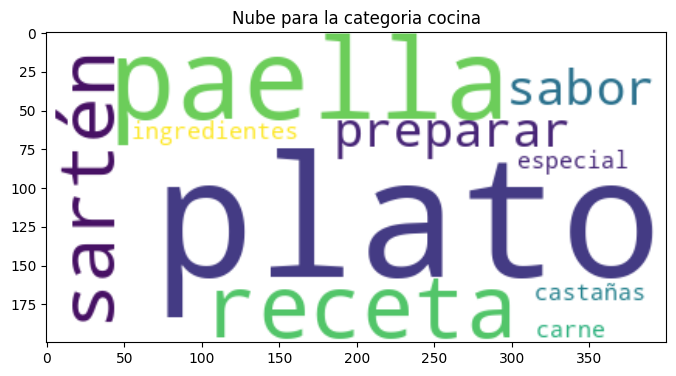

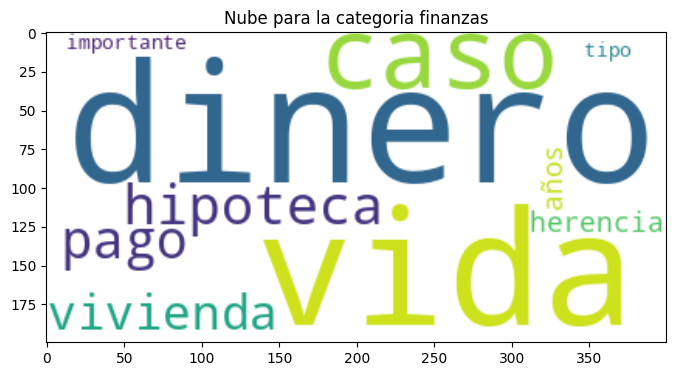

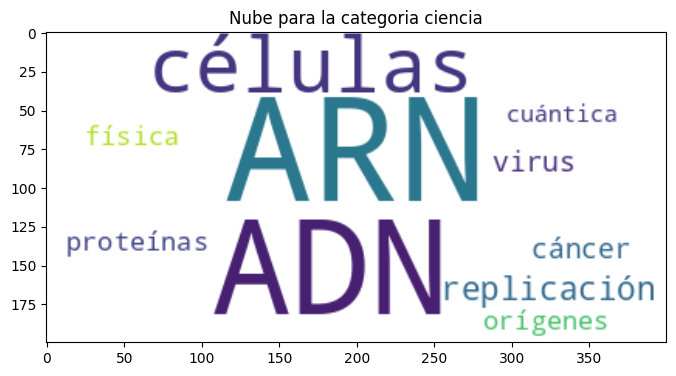

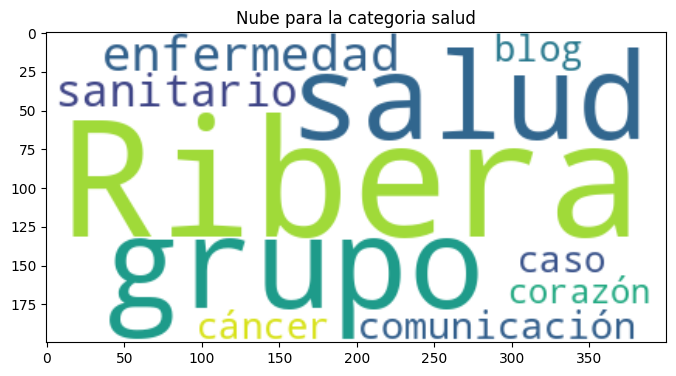

In [ ]:

nlp = spacy.load("es_core_news_md")
palabras_importantes = {}

for categoria in df['categoria'].unique():
  textos_categoria = df[df['categoria'] == categoria]['texto']
  texto_combinado = " ".join(textos_categoria)
  doc = nlp(texto_combinado)
  frecuencia = Counter(token.text for token in doc if not token.is_stop and token.is_alpha)
  palabras_top = frecuencia.most_common(10)
  palabras_importantes[categoria] = palabras_top

for categoria, palabras_top in palabras_importantes.items():
  print(f'categoria: {categoria}')
  for palabra, frecuencia in palabras_top:
    print(f'{palabra}: {frecuencia}')

for categoria, palabras_top in palabras_importantes.items():
  nube = WordCloud(background_color = 'white').generate_from_frequencies(dict(palabras_top))
  plt.figure(figsize = (8,8))
  plt.imshow(nube, interpolation = 'bilinear')
  plt.title(f'Nube para la categoria {categoria}')
  plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer, util
from prettytable import PrettyTable

# Cargamos el modelo preentrenado multilingüe
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

oraciones = list(df[df['categoria'] == 'ciencia']['titulo'])
# Codificamos las oraciones
embeddings = modelo.encode(oraciones, convert_to_tensor=True)
# Calculamos las puntuaciones de similitud
puntuaciones_coseno = util.cos_sim(embeddings, embeddings)
# Encontramos las puntuaciones de similitud más altas
pares = []
for i in range(len(puntuaciones_coseno)-1):
  for j in range(i+1, len(puntuaciones_coseno)):
    pares.append({'index': [i, j], 'score': puntuaciones_coseno[i][j]})

# Ordenamos las puntuaciones en orden decreciente
pares = sorted(pares, key=lambda x: x['score'], reverse=True)

# Creamos una tabla para mostrar los resultados
tabla = PrettyTable()
tabla.field_names = ["Oración 1", "Oración 2", "Puntuación de Similitud"]
# Añadimos las filas a la tabla
for par in pares:
  i, j = par['index']
  tabla.add_row([oraciones[i], oraciones[j], f"{par['score']:.4f}"])
# Mostramos la tabla
print(tabla)


+-------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+-------------------------+
|                                            Oración 1                                            |                                            Oración 2                                            | Puntuación de Similitud |
+-------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------+-------------------------+
|                            Bacterias diseñadas para detectar tumores                            |          Búsqueda de marcadores no invasivos para el diagnóstico del cáncer colorrectal         |          0.5135         |
|                El ARN naciente como regulador de la replicación del genoma humano               |     

In [ ]:
!pip install gensim
# Importar las librerías necesarias
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Datos de ejemplo en español
data = list(df[df['categoria'] == 'ciencia']['titulo'])
# Tokenizar los datos y etiquetarlos
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# Configurar parámetros para el modelo
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=1000)
# Construir el vocabulario
model.build_vocab(tagged_data)
# Entrenar el modelo
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
# Obtener el vector de un documento
for oracion in data:
  vector = model.infer_vector(word_tokenize(oracion.lower()))
  similares = model.docvecs.most_similar([vector], topn=2)
  etiqueta_similar, similitud = similares[1]
  print(f"La frase más cercana a {oracion} es: '{data[int(etiqueta_similar)]}' con una similitud de {similitud}.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-22-95d793b304bd>:21: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similares = model.docvecs.most_similar([vector], topn=2)


La frase más cercana a Divulgación científica para niños. Carlos Pazos es: 'Bacterias diseñadas para detectar tumores' con una similitud de 0.536819338798523.
La frase más cercana a Física cuántica: El experimento de la doble rendija es: 'Premio Nobel de Física de 2023: pulsos de luz de attosegundos' con una similitud de 0.4268780052661896.
La frase más cercana a Bacterias diseñadas para detectar tumores es: 'Divulgación científica para niños. Carlos Pazos' con una similitud de 0.5553397536277771.
La frase más cercana a El ARN naciente como regulador de la replicación del genoma humano es: 'ARNs largos no codificantes (lncRNAs) como biomarcadores de cáncer' con una similitud de 0.371496319770813.
La frase más cercana a Búsqueda de marcadores no invasivos para el diagnóstico del cáncer colorrectal es: 'Bacterias diseñadas para detectar tumores' con una similitud de 0.42125049233436584.
La frase más cercana a ARNs largos no codificantes (lncRNAs) como biomarcadores de cáncer es: 'Divulga

In [ ]:
eleccion = input("elegir categoria entre: cocina, salud, finanzas, ciencia")


# Definimos una función para manejar y limpiar espacios en blanco y saltos de línea
WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
for texto in df.loc[df['categoria'] == eleccion, 'texto']:
  article_text = texto

  model_name = "csebuetnlp/mT5_multilingual_XLSum"

  # Cargamos el tokenizador y el modelo del nombre especificado
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

  # Convertimos el texto del artículo en IDs de entrada usando el tokenizador
  input_ids = tokenizer(
      [WHITESPACE_HANDLER(article_text)],
      return_tensors="pt",
      padding="max_length",
      truncation=True,
      max_length=912
  )["input_ids"]

  # Generamos el resumen usando el modelo
  output_ids = model.generate(
      input_ids=input_ids,
      max_length=84,
      no_repeat_ngram_size=2,
      num_beams=4
  )[0]

  # Decodificamos los IDs de salida para obtener el resumen en texto
  summary = tokenizer.decode(
      output_ids,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False
  )

  # Imprimimos el resumen
  print(f'Artículo:\n{article_text}\n')
  print(f'Resumen:\n{summary}\n')